<a href="https://colab.research.google.com/github/towardsai/ai-tutor-rag-system/blob/notebook%2Faman/notebooks/PerplexityApi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import neccessary library

In [ ]:
pip install llama-index==0.11.9 llama-index-llms-perplexity==0.2.0 llama-index-llms-openai==0.2.7 --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 21.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.6/375.6 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.4/187.4 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 1.6 MB/s eta 0:00:00


## Setup Enviornment variables

In [ ]:
import os
os.environ["OPENAI_API_KEY"] = "<OPENAI_API_KEY>"
PERPLEXITY_API_KEY = "<PERPLEXITY_API_KEY>"

## FlowDiagram
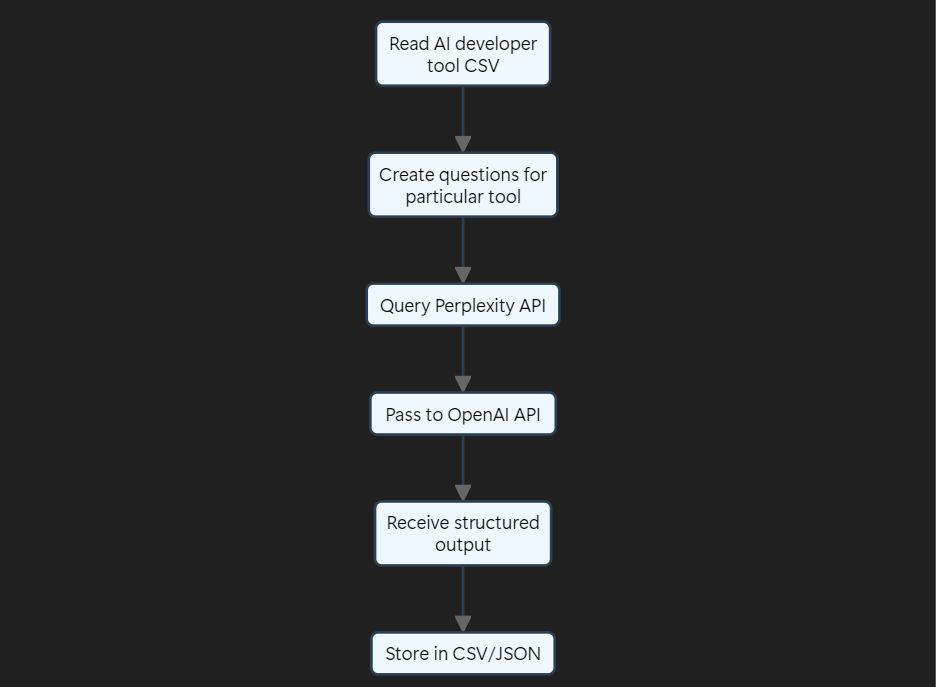

## Read the CSV for tool name

In [ ]:
import requests
import csv

# Google Sheets file URL (CSV export link)
url = 'https://docs.google.com/spreadsheets/d/1gHB-aQJGt9Nl3cyOP2GorAkBI_Us2AqkYnfqrmejStc/export?format=csv'

# Send a GET request to fetch the CSV file
response = requests.get(url)

response_list = []
# Check if the request was successful
if response.status_code == 200:
    # Decode the content to a string
    content = response.content.decode('utf-8')

    # Use the csv.DictReader to read the content as a dictionary
    csv_reader = csv.DictReader(content.splitlines(), delimiter=',')
    response_list = [row for row in csv_reader]
else:
    print(f"Failed to retrieve the file: {response.status_code}")

In [ ]:
response_list[0:3]

[{'Name': 'Microsoft Azure AI Platform',
  'Tool Type': 'Cloud Platform',
  'Parent': '',
  'Company': '',
  'Description': 'Cloud-based environment for training, deploying, automating, managing, and tracking ML models',
  'Category': 'Cloud ML Platform',
  'URL': 'https://azure.microsoft.com/en-us/products/machine-learning',
  'Is a direct URL company /tool website?': 'Yes',
  '': ''},
 {'Name': 'Vertex AI Platform',
  'Tool Type': 'Cloud Platform',
  'Parent': 'Google Cloud Platform',
  'Company': '',
  'Description': 'A Google Cloud platform for AI and machine learning development and deployment',
  'Category': 'GPUs and AI APIs',
  'URL': 'https://cloud.google.com/vertex-ai',
  'Is a direct URL company /tool website?': 'No',
  '': ''},
 {'Name': 'Google Cloud Platform',
  'Tool Type': 'Cloud Platform',
  'Parent': '',
  'Company': '',
  'Description': '',
  'Category': '',
  'URL': '',
  'Is a direct URL company /tool website?': '',
  '': ''}]

## Create the questions for tool name

In [ ]:
def create_questions_list(tool_name):
    questions_list = [
    f"Describe the developer tool `{tool_name}` in detail. What type of product is it, what types of tasks it is used for? What are the key features and capabilities of the tool? Explain Briefly",
    f"""
    Given the information about {tool_name}:
    **Parent Tools or languages**: Give a comma separated list of direct parent software languages or tools it uses. eg for Autokeras this would be; Keras, Python.
    **Languages it supports**: [List the programming languages {tool_name} this tool can be imported into, based on official documentation]
    Explain Briefly""",
    f"What other software tools are used in conjunction with {tool_name}. Explain Briefly",
    f"What company built and owns {tool_name} Is the product open source? Explain Briefly",
    ]
    return questions_list

# Perplexity API

In [ ]:
from llama_index.core.llms import ChatMessage
from llama_index.llms.perplexity import Perplexity

def get_response_from_perplexity(question: str, llm):
    """
    Get a response from Perplexity LLM for a given question.

    Args:
        question (str): The question to ask.
        llm: The Perplexity LLM instance.

    Returns:
        The response from the LLM.
    """
    messages_dict = [
    {"role": "system", "content": "Be Precise and concise"},
    {"role": "user", "content": question},
    ]
    messages = [ChatMessage(**msg) for msg in messages_dict]
    response = llm.chat(messages)
    return response

# Get Perplexity Response For particular tool

In [ ]:
# Get tool Response From perplexity

In [ ]:
def get_tool_response_perplexity(llm, tool_name):
    questions_list = [
    f"Describe the developer tool `{tool_name}` in detail. What type of product is it, what types of tasks it is used for? What are the key features and capabilities of the tool? Explain Briefly",
    f"""
    Given the information about {tool_name}:
    **Parent Tools or languages**: Give a comma separated list of direct parent software languages or tools it uses. eg for Autokeras this would be; Keras, Python.
    **Languages it supports**: [List the programming languages {tool_name} this tool can be imported into, based on official documentation]
    Explain Briefly""",
    f"What other software tools are used in conjunction with {tool_name}. Explain Briefly",
    f"What company built and owns {tool_name} Is the product open source? Explain Briefly",
    ]

    response_list = []
    for question in questions_list:
        response = get_response_from_perplexity(question, llm)
        answer = str(response)
        response_list.append({"question": question, "answer": str(response)})
    return response_list

## Intialize Structured Output pydantic format


In [ ]:
from pydantic import BaseModel, Field
class ToolInformationOutput(BaseModel):
    description: str = Field(..., description="Give a 4 sentence description of the tool in one full paragraph.")
    parent: str = Field(..., description="Give a comma separated list of direct parent software tools it uses / is dependent on.")
    languages: list[str] = Field(..., description="Give a comma separated list of compatible software languages.")
    mapping: list[str] = Field(..., description="Give a comma separated list of alternative spellings of this tool. Include acronyms (or full words if the acronym was given for the tool name)")
    category: list[str] = Field(..., description="Give a comma separated list of the types of task the product is used for. Use only 1-3 word category names not full complex sentences.")
    related_tools: list[str] = Field(..., description="What other tools is it compatible with? Give a comma separated list of the types of task the product is used for. Use only 1-3 word category names not full complex sentences.")
    company: str = Field(..., description="What company or organisation owns/builds the tool?")


# Define System Prompt to get the output from open ai

In [ ]:
system_prompt = """
You have researched a specific AI developer tool which could be a tool, platform, library, framework, language or model (among others). You will output information about this in this specific format:

Here are some further instructions;
Don’t use over the top or dramatic language like groundbreaking, mindblowing etc.
Don’t use strong terms like “amazing”, “intriguing”, “fascinating”, “must-read”, or “outstanding”.
Do NOT use these words; “embarking”, “delve”, “vibrant”, “realm”, “endeavour” or “dive into”.

Fields should only be filled if the information is available in the following context. Otherwise, leave the field empty.
Here are the source materials from you research to use:
{context}
"""

## Create QueryPipeline which contain prompt and llm

In [ ]:
from llama_index.core.query_pipeline import QueryPipeline
def get_structured_output(openai_llm, context):
    prompt_template = PromptTemplate(
        template=system_prompt,
    )

    # you can get structured output in llamaindex by using the below code.
    structured_llm = openai_llm.as_structured_llm(ToolInformationOutput)
    p = QueryPipeline(chain=[prompt_template, structured_llm])
    result = p.run(context)
    return result

## Execute the workflow

In [ ]:
from llama_index.core.llms import ChatMessage
from llama_index.llms.openai import OpenAI
from llama_index.core import PromptTemplate
from llama_index.llms.perplexity import Perplexity

perplexity_llm = Perplexity(
    api_key=PERPLEXITY_API_KEY, model="llama-3.1-sonar-large-128k-online", temperature=0.2
)
openai_llm = OpenAI(model="gpt-4o", temprature=0.1)

response_dict = {}

# Here we will process only 5 tools for demonstration purpose.
# You can process all the tools by removing the slicing [0:5], but you'll
# use the API more, thus incurring in higher costs. Be careful with that and
# always check the costs of the APIs you are using.
for csv_dict in response_list[0:5]:
    tool_name = csv_dict.get("Name")
    try:
        perplexity_response = get_tool_response_perplexity(perplexity_llm, tool_name)
        # get all the answer response of perplexity and create the context to pass it in llm.
        context = "\n".join(response.get("answer") for response in perplexity_response)
        structured_output = get_structured_output(openai_llm, context)
        # convert pydantic into json
        output_dict = structured_output.model_dump()
        response_dict[tool_name] = output_dict
        print(f"Processed {tool_name}")
    except Exception as e:
        print(f"Error processing {tool_name}: {e}")

Processed Microsoft Azure AI Platform
Processed Vertex AI Platform
Processed Google Cloud Platform
Processed DataRobot Enterprise AI Platform
Processed Google AI Studio


In [ ]:
import pprint
# Lets Visualize the result
for tool_name, tool_info in response_dict.items():
    print(f"Tool Name: {tool_name}")
    print(f"Description: {tool_info.get('description', 'N/A')}")
    pprint.pprint(tool_info)
    break

Tool Name: Microsoft Azure AI Platform
Description: Microsoft Azure AI Platform is a comprehensive artificial intelligence and machine learning development platform offered within the Microsoft Azure ecosystem. It supports a wide range of AI-related tasks including machine learning, natural language processing, computer vision, and decision-making systems. The platform provides robust AI models, generative AI capabilities, multimodal AI, and tools for responsible AI. It also offers scalability, security, flexible deployment options, and a collaborative development environment.
{'category': ['Machine Learning',
              'Natural Language Processing',
              'Computer Vision',
              'Decision Making'],
 'company': 'Microsoft',
 'description': 'Microsoft Azure AI Platform is a comprehensive artificial '
                'intelligence and machine learning development platform '
                'offered within the Microsoft Azure ecosystem. It supports a '
               

## Store the structured output in csv

In [ ]:
import csv
import os

# Function to check if file exists
def file_exists(filename):
    return os.path.isfile(filename)

# Create a list to store the data for the CSV
data = []

# Iterate over the tool_output_dict
for tool_name, tool_info in response_dict.items():
    # Extract the relevant information
    description = tool_info.get("description", "")
    parent = tool_info.get("parent", "")
    languages = ", ".join(tool_info.get("languages", []))
    mapping = ", ".join(tool_info.get("mapping", []))
    category = ", ".join(tool_info.get("category", []))
    related_tools = ", ".join(tool_info.get("related_tools", []))
    company = tool_info.get("company", "")

    # Add the data for the current tool to the list
    data.append([tool_name, description, parent, languages, mapping, category, related_tools, company])

# Write or append the data to the CSV file
tool_output_filename = 'tool_output.csv'
file_exists_flag = file_exists(tool_output_filename)

with open(tool_output_filename, 'a' if file_exists_flag else 'w', newline='', encoding='utf-8') as csvfile:
    writer = csv.writer(csvfile)

    # Write the header only if the file is being created for the first time
    if not file_exists_flag:
        writer.writerow(["Tool Name", "Description", "Parent", "Languages", "Mapping", "Category", "Related Tools", "Company"])

    # Append the data rows
    writer.writerows(data)


## END